# Explaining Outcomes from Binary Classifiers

This notebook demonstrates how SLISE can be used to explain outcomes from black box models, and especially binary classifiers.
The notebook builds upon the previous example notebook (`1_tabular_explanation.ipynb`), but uses a different dataset and discusses considerations required for explaining classifications.

## Prerequisites

- SLISE (for explanations)
- numpy (for numerical operations)
- matplotlib (for plots)
- wordcloud (for plots)
- nltk (for text pre-processing)
- tensorflow (for keras, neural networks, and data loading)

In [1]:
import numpy as np
from tensorflow import keras
import slise
from slise.plot import SLISE_COLORMAP, SLISE_ORANGE, SLISE_PURPLE
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from wordcloud import WordCloud
from nltk import PorterStemmer, download as nltk_download
from nltk.corpus import stopwords

plt.rcParams['figure.figsize'] = [10, 6]
try:
    stopwords.words("english")
except:
    nltk_download('stopwords')

## Dataset

The dataset consists of reviews from IMDB and the task is to determine the sentiment: positive or negative. We will be using a bag-of-words model so we need to do some cleanup, consisting of the removal of stop words and stemming:

In [2]:
# Get the words from the dataset
word_to_index = keras.datasets.imdb.get_word_index()
index_to_word = [""] * (len(word_to_index) + 4)
for w in word_to_index:
    index_to_word[word_to_index[w] + 3] = w
index_to_word[word_to_index["br"] + 3] = "\n"
index_to_word[0] = ""

# Sanitise the words
stops = set(stopwords.words("english"))
porter = PorterStemmer()
index_to_stem = index_to_word.copy()
for i, w in enumerate(index_to_stem):
    w = w.lower().strip()
    if w.startswith("'"):
        w = w[1:]
    if w.endswith("'"):
        w = w[:-1]
    if w in stops:
        w = ""
    w = porter.stem(w)
    index_to_stem[i] = w

# create new indices
stem_to_newindex = {"": 0}
counter = 1
for w in index_to_stem:
    if w and w not in stem_to_newindex:
        stem_to_newindex[w] = counter
        counter += 1
index_to_newindex = [stem_to_newindex[s] for s in index_to_stem]
newindex_to_stem = [s for s in stem_to_newindex]

Note that the reviews are normalised by dividing by the most frequent word. We also use label smoothing to avoid an over-confident model. Over-confident models mostly produce predictions that are very close to either one or zero. This goves us fewer "bits of information" than if the predictions are more spread out, which makes the creation of post-hoc explanations more difficult. Label smoothing is very easy to implement (one line) and should not affect the accuracy (it might even improve it, due to the slight regularising effect).

In [3]:
(l_train, y_train), (l_test, y_test) = keras.datasets.imdb.load_data()

# Construct the bag-of-words model using the stemmed words
x_train = np.zeros((len(y_train), len(stem_to_newindex)))
for i, l in enumerate(l_train):
    ind, cnt = np.unique([index_to_newindex[i] for i in l if i < len(index_to_newindex)], return_counts=True)
    x_train[i, ind] = cnt
x_test = np.zeros((len(y_test), len(stem_to_newindex)))
for i, l in enumerate(l_test):
    ind, cnt = np.unique([index_to_newindex[i] for i in l if i < len(index_to_newindex)], return_counts=True)
    x_test[i, ind] = cnt

# Select the 1000 most common (stemmed) words
mask = np.argsort(-x_test.sum(0),)[1:1001]
x_train = x_train[:, mask]
x_test = x_test[:, mask]
selected_words = [newindex_to_stem[i] for i in mask]

# Normalise by dividing by the most frequent word
x_train = x_train / x_train.max(1, keepdims=True)
x_test = x_test / x_test.max(1, keepdims=True)

# Label smoothing
y_train = y_train * 0.8 + 0.1

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\anton\miniconda3\envs\slise\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\anton\miniconda3\envs\slise\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) i

## Model

The model is a simple neural network with ReLU activations, batch normalisation, and dropout. The final activation is a *sigmoid* function that turns unconstrained values into values between zero and one, so that they can be interpreted as (pseudo) probabilities. 

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=x_train.shape[1]),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [5]:
# Train the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=256, epochs=8, validation_split=0.1)

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/8
88/88 [==============================] - 0s 5ms/step - loss: 0.6637 - accuracy: 0.0000e+00 - val_loss: 0.6510 - val_accuracy: 0.0000e+00
Epoch 2/8
88/88 [==============================] - 0s 3ms/step - loss: 0.5125 - accuracy: 0.0000e+00 - val_loss: 0.5916 - val_accuracy: 0.0000e+00
Epoch 3/8
88/88 [==============================] - 0s 4ms/step - loss: 0.4781 - accuracy: 0.0000e+00 - val_loss: 0.5429 - val_accuracy: 0.0000e+00
Epoch 4/8
88/88 [==============================] - 0s 4ms/step - loss: 0.4537 - accuracy: 0.0000e+00 - val_loss: 0.5054 - val_accuracy: 0.0000e+00
Epoch 5/8
88/88 [==============================] - 0s 3ms/step - loss: 0.4360 - accuracy: 0.0000e+00 - val_loss: 0.4946 - val_accuracy: 0.0000e+00
Epoch 6/8
88/88 [==============================] - 0s 3ms/step - loss: 0.4182 - accuracy: 0.0000e+00 - val_loss: 0.4949 - val_accuracy: 0.0000e+00
Epoch 7/8
88/88 [==============================] - 0s 3ms/step - loss: 0.4023 - accuracy: 0.0000e+00 - val_loss: 0.509

## Explanation

The explanation process starts with generating predictions for the data used for the explanations. Since the data is already in vector form (due to the bag-of-words) we can use it as is.

In [6]:
p_test = model.predict(x_test).ravel()
p_train = model.predict(x_train).ravel()

Then we need to select which review (and prediction) we are interested in investigating:

In [7]:
item = 15
l_item = l_test[item]
x_item = x_test[item]
y_item = y_test[item]
p_item = p_test[item]
mask_item = x_item > 0
print("IMDB Review:")
print("", " ".join(index_to_word[i] for i in l_item))
print("\nSentiment:", "Positive" if y_item > 0 else "Negative")
if p_item < 0.5:
    print(f"Predicted: {100 - p_item * 100:.1f}% Negative")
else:
    print(f"Predicted: {p_item * 100:.1f}% Positive")

IMDB Review:
  let me first start out by saying 1 out of 10 is too good for this movie it's unfortunate that imdb doesn't have tenths of a star i watched this abortion of a movie in the middle of the night due to insomnia and it was absolute garbage the plot was horrible the acting was horrible the movie was utterly boring looked like the shadow with alec baldwin the shadow is infinitely better than this as well the character eve was so undeveloped and 2 dimensional she didn't even grab my attention i didn't even know her name was eve don was interesting when he kept his mouth shut the twist if you can call it that was laughable and pathetic when it came the movie had done such a horrid job of building suspense or attachment to any character that i simply thought who gives a s the only thing that made me even lift an eyebrow about this movie was the fact the med teacher was dyson in terminator 2 also a movie that was light years ahead of this motion picture massacre anyone who was invo

When it comes to do the actual explanation there are three choices worth discussing in more detail:

1. The *logit* transformation can be used to turn probabilities into unconstrained values. This makes the resulting model (that SLISE gives) similar to logistic regression instead of just a plain linear regression. Considering that we are explaining a classifier, it makes sense if the simple model has classifier-like properties as well. In this case, the *logit* transformation is especially suitable since it is the inverse of the *sigmoid* function (so what we are doing is removing the last activation function from the neural network). Since this is such a common thing to do, SLISE has the *logit* transformation built-in as an optional part of the explanation process, which can be activated by specifying `logit=True` as a parameter.

2. With SLISE we can alter the question (explanation) we are asking by selecting the data used for the explanation. To make the explanations even more local we are only interested in the words that appeared in the review we are investigating. This is easily accomplished by only selecting the columns where the explained item is non-zero.

3. The data already has some kind of normalisation done to it (division by the most frequent word, see above), so we don't need to use the normalisation offered by SLISE.

In [8]:
explanation = slise.explain(x_train[:, mask_item], p_train, 2.0, x_item[mask_item], p_item, lambda1=20, logit=True)
print("Neighbourhood size:", explanation.subset().mean())

C:\Users\anton\miniconda3\envs\slise\lib\site-packages\lbfgs\__init__.py:202: UserWarning: The line-search routine reaches the maximum number of evaluations.
  return opt.minimize(f, x0, progress=progress, args=args)
C:\Users\anton\miniconda3\envs\slise\lib\site-packages\slise\optimisation.py:190: SliseWarning: An optimisation step reaches the maximum number of iterations.
  warn(
Neighbourhood size: 0.76388


To visualise the explanation we use a word cloud. Some words in the could might seem a bit strange, like the end has been chopped off. This is due to the stemming when creating the bag-of-words (so that, e.g., car and cars are merged to count towards the same word). The evidence that this review is negative is mainly based upon the occurances of the words *horrible* and *wasting* in the review, which seems like a reasonable conclusion.

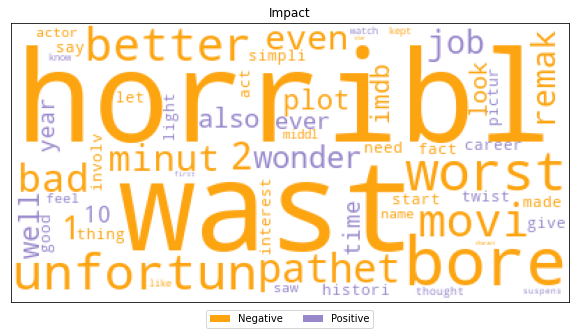

In [9]:
def plot_wordcloud(words, weights, title, gradient = False):
    if gradient:
        colors = [
            tuple(int(c * 255) for c in SLISE_COLORMAP(w)[:-1])
            for w in weights / np.max(np.abs(weights)) * 0.5 + 0.5
        ]
    else:
        colors = [SLISE_ORANGE if v < 0 else SLISE_PURPLE for v in weights]
    freqs = {w:np.abs(f) for w, f in zip(words, weights) if f != 0}
    colors = {w:c for w, c in zip(words, colors)}
    wc = WordCloud(background_color="white", color_func=lambda w, **_: colors[w])
    plt.imshow(wc.generate_from_frequencies(freqs))
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.legend(
        (Patch(facecolor=SLISE_ORANGE), Patch(facecolor=SLISE_PURPLE)),
        ("Negative", "Positive"),
        loc="upper center",
        bbox_to_anchor=(0.5, -0.01),
        ncol=2,
    )
    plt.show()

words = [w for w, m in zip(selected_words, mask_item) if m]
# plot_wordcloud(words, explanation.alpha[1:], "Linear Model")
plot_wordcloud(words, explanation.get_impact()[1:], "Impact")

In [ ]:
Lets also look at a second review, a positive one:

In [10]:
item = 25 
l_item = l_test[item]
x_item = x_test[item]
y_item = y_test[item]
p_item = p_test[item]
mask_item = x_item > 0
print("IMDB Review:")
print("", " ".join(index_to_word[i] for i in l_item))
print("\nSentiment:", "Positive" if y_item > 0 else "Negative")
if p_item < 0.5:
    print(f"Predicted: {100 - p_item * 100:.1f}% Negative")
else:
    print(f"Predicted: {p_item * 100:.1f}% Positive")

IMDB Review:
  i'm not sure why this film is averaging so low on imdb when it's absolutely everything you could ever want in a horror film this is the definition of being a horror film i consider myself to be a big horror fan and i must say that this house delivers the goods house of wax is the story of a group of college kids on their way to a football game whom decide to camp out for the night and have a run in with a local weirdo upon waking the next morning they make a gruesome discovery and decide to go into town for a broken car part the town is creepy and i'm just gonna stop there because thats when the truly gruesome mayhem begins trust me when i say if your looking for a horror film go see this you will love it it's wonderfully diabolical and inventive with it's killing scenes the story is interesting and the characters are decently drawn with the actors giving them gobs of personality paris hilton included whom does quite well with her part the film lies a little on the shall

Using the same parameters as above we get a smaller neighbourhood (subset). This demonstrates how the explanation and neighbourhood depends on the item we are explaining (which is the goal of local explanations).

In [11]:
explanation = slise.explain(x_train[:, mask_item], p_train, 2.0, x_item[mask_item], p_item, lambda1=20, logit=True)
print("Neighbourhood size:", explanation.subset().mean())

Neighbourhood size: 0.70648


This explanation is more interesting. The largest impact (i.e. the largest font size) is given to the *9*. Since the review has the score embedded (9/10) this is an obvious give-away that the review is positive. It's a good thing that the model learns obvious clues, but in this case we might want to go back to the data pre-processing and remove all numbers (i.e. we can use explanations as a tool to debug and improve the model).

The explanation also highlights *house* and *town* as positive indicators, which is unexpected. These words are used to decribe the setting of a movie, something that might be described in a positive review. A bad movie is probably bad for other reasons than the setting, so it might not get mentioned at all in a negative review. This means that using *house* and *town* as positive indicators is somewhat reasonable.

The word *decent* is usually positive, but the model/explanation thinks that it is negative. This discrepancy comes from the context: In a positive review you would probably use stronger words than *decent* and in a negative review you might want to balance the negativity by admitting that some aspect was at least *decent*.

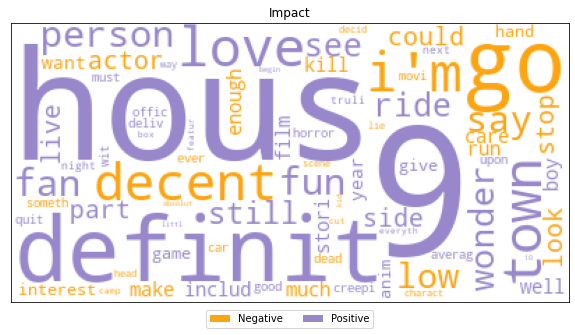

In [12]:
words = [w for w, m in zip(selected_words, mask_item) if m]
# plot_wordcloud(words, explanation.alpha[1:], "Linear Model")
plot_wordcloud(words, explanation.get_impact()[1:], "Impact")

## Conclusions

Explanations tries to encover some of the inner workings (but not all) of complex models. Even by just locally approximating the complex model with a simpler one, we can get valuable insights about the model **and the data** (that's why the data is so important for SLISE). 

Explanations acts in between complex models and human users. Just as the explanation cannot completely replace the complex model, the user still has to do some interpretation (there is a trade-off between replicating the complex model and interpretability). By keeping the building blocks of the explanation simple (SLISE uses an approximating linear model) we can ease the interpretation and make it possible to create visualisations that suits the task at hand (e.g. word clouds).

A linear regression model (designed for unconstrained space) might not seem like the best model to approximate a classifier giving probabilities. However, probabilities can be turned to unconstrained values, and this is commonly done using the *logit* transformation. Thus, SLISE supports this mode of operation (and it is even the recommended approach for classifiers).